## Combining of  SAKT with Riiid LGBM bagging2 then remove some features

Source Kernels
* SAKT + Riiid LGBM bagging2 LB 0.780 [https://www.kaggle.com/leadbest/sakt-riiid-lgbm-bagging2](http://)
* SAKT with Randomization & State Updates LB0.771 https://www.kaggle.com/leadbest/sakt-with-randomization-state-updates
* Riiid! LGBM bagging2 LB0.772 https://www.kaggle.com/zephyrwang666/riiid-lgbm-bagging2

In [1]:
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl > /dev/null 2>&1

In [2]:
import numpy as np
import pandas as pd
import psutil

from collections import defaultdict
import datatable as dt
import lightgbm as lgb
from matplotlib import pyplot as plt
import riiideducation
import random
from sklearn.metrics import roc_auc_score
import gc

_ = np.seterr(divide='ignore', invalid='ignore')

# Preprocess

In [3]:
data_types_dict = {
    'timestamp': 'int64',
    'user_id': 'int32', 
    'content_id': 'int16', 
    'content_type_id':'int8', 
    'task_container_id': 'int16',
    #'user_answer': 'int8',
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'

In [4]:
train_df = dt.fread('../input/riiid-test-answer-prediction/train.csv', columns=set(data_types_dict.keys())).to_pandas()

In [5]:
print(psutil.virtual_memory().percent)

15.5


In [6]:
#reading in lecture df
lectures_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/lectures.csv')

In [7]:
lectures_df['type_of'] = lectures_df['type_of'].replace('solving question', 'solving_question')

lectures_df = pd.get_dummies(lectures_df, columns=['part', 'type_of'])

part_lectures_columns = [column for column in lectures_df.columns if column.startswith('part')]

types_of_lectures_columns = [column for column in lectures_df.columns if column.startswith('type_of_')]

In [8]:
train_lectures = train_df[train_df.content_type_id == True].merge(lectures_df, left_on='content_id', right_on='lecture_id', how='left')

In [9]:
user_lecture_stats_part = train_lectures.groupby('user_id',as_index = False)[part_lectures_columns + types_of_lectures_columns].sum()

In [10]:
lecturedata_types_dict = {   
    'user_id': 'int32', 
    'part_1': 'int8',
    'part_2': 'int8',
    'part_3': 'int8',
    'part_4': 'int8',
    'part_5': 'int8',
    'part_6': 'int8',
    'part_7': 'int8',
    'type_of_concept': 'int8',
    'type_of_intention': 'int8',
    'type_of_solving_question': 'int8',
    'type_of_starter': 'int8'
}
user_lecture_stats_part = user_lecture_stats_part.astype(lecturedata_types_dict)

In [11]:
for column in user_lecture_stats_part.columns:
    #bool_column = column + '_boolean'
    if(column !='user_id'):
        user_lecture_stats_part[column] = (user_lecture_stats_part[column] > 0).astype('int8')

In [12]:
train_lectures[train_lectures.user_id==5382]

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lecture_id,tag,...,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
1,10183847,5382,16736,True,21,-1,NaN,False,16736,40,...,0,0,0,0,0,0,1,0,0,0
2,1424348597,5382,30207,True,104,-1,NaN,False,30207,43,...,0,0,0,1,0,0,1,0,0,0
3,1425557777,5382,18545,True,121,-1,NaN,False,18545,58,...,0,0,0,1,0,0,1,0,0,0


In [13]:
user_lecture_stats_part[user_lecture_stats_part.user_id==5382]

,user_id,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
1,5382,1,0,0,0,1,0,0,1,0,0,0


In [14]:
user_lecture_stats_part.tail()

,user_id,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
149601,2147419988,1,0,1,0,1,1,0,1,0,1,0
149602,2147469944,1,0,0,1,1,0,0,1,0,0,0
149603,2147470770,0,0,0,0,1,0,0,1,0,0,0
149604,2147470777,0,0,0,1,1,0,0,1,0,0,0
149605,2147482216,0,1,0,0,0,0,0,1,1,0,0


In [15]:
user_lecture_stats_part.dtypes

user_id                     int32
part_1                       int8
part_2                       int8
part_3                       int8
part_4                       int8
part_5                       int8
part_6                       int8
part_7                       int8
type_of_concept              int8
type_of_intention            int8
type_of_solving_question     int8
type_of_starter              int8
dtype: object

In [16]:
#clearing memory
del(train_lectures)

In [17]:
print(psutil.virtual_memory().percent)

28.7


In [18]:
cum = train_df.groupby('user_id')['content_type_id'].agg(['cumsum', 'cumcount'])
train_df['user_lecture_cumsum'] = cum['cumsum'] 
train_df['user_lecture_lv'] = cum['cumsum'] / cum['cumcount']


train_df.user_lecture_lv=train_df.user_lecture_lv.astype('float16')
train_df.user_lecture_cumsum=train_df.user_lecture_cumsum.astype('int8')
user_lecture_agg = train_df.groupby('user_id')['content_type_id'].agg(['sum', 'count'])

In [19]:
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df = train_df.astype(data_types_dict)
train_df = train_df[train_df[target] != -1].reset_index(drop=True)
prior_question_elapsed_time_mean=train_df['prior_question_elapsed_time'].mean()
train_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)

In [20]:
max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max']).reset_index()
#max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max'])
max_timestamp_u.columns = ['user_id', 'max_time_stamp']

In [21]:

train_df['lagtime'] = train_df.groupby('user_id')['timestamp'].shift()
train_df['lagtime']=train_df['timestamp']-train_df['lagtime']
train_df['lagtime'].fillna(0, inplace=True)
train_df.lagtime=train_df.lagtime.astype('int32')
#train_df.drop(columns=['timestamp'], inplace=True)

In [22]:
lagtime_agg = train_df.groupby('user_id')['lagtime'].agg(['mean'])
train_df['lagtime_mean'] = train_df['user_id'].map(lagtime_agg['mean'])
train_df.lagtime_mean=train_df.lagtime_mean.astype('int32')

In [23]:
user_prior_question_elapsed_time = train_df[['user_id','prior_question_elapsed_time']].groupby(['user_id']).tail(1)
#max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max'])
user_prior_question_elapsed_time.columns = ['user_id', 'prior_question_elapsed_time']

In [24]:

train_df['delta_prior_question_elapsed_time'] = train_df.groupby('user_id')['prior_question_elapsed_time'].shift()
train_df['delta_prior_question_elapsed_time']=train_df['prior_question_elapsed_time']-train_df['delta_prior_question_elapsed_time']
train_df['delta_prior_question_elapsed_time'].fillna(0, inplace=True)


In [25]:
train_df.delta_prior_question_elapsed_time=train_df.delta_prior_question_elapsed_time.astype('int32')

In [26]:
train_df['timestamp']=train_df['timestamp']/(1000*3600)
train_df.timestamp=train_df.timestamp.astype('int16')
#

In [27]:

train_df['lag'] = train_df.groupby('user_id')[target].shift()

cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
train_df['user_correct_cumsum'] = cum['cumsum']
train_df['user_correct_cumcount'] = cum['cumcount']
train_df.drop(columns=['lag'], inplace=True)

# train_df['user_correctness'].fillna(1, inplace=True)
train_df['user_correct_cumsum'].fillna(0, inplace=True)
#train_df['user_correct_cumcount'].fillna(0, inplace=True)
train_df.user_correctness=train_df.user_correctness.astype('float16')
train_df.user_correct_cumcount=train_df.user_correct_cumcount.astype('int16')
train_df.user_correct_cumsum=train_df.user_correct_cumsum.astype('int16')

In [28]:
train_df.prior_question_had_explanation=train_df.prior_question_had_explanation.astype('int8')

train_df['lag'] = train_df.groupby('user_id')['prior_question_had_explanation'].shift()

In [29]:

cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
train_df['explanation_mean'] = cum['cumsum'] / cum['cumcount']
train_df['explanation_cumsum'] = cum['cumsum'] 
train_df.drop(columns=['lag'], inplace=True)

train_df['explanation_mean'].fillna(0, inplace=True)
train_df['explanation_cumsum'].fillna(0, inplace=True)
train_df.explanation_mean=train_df.explanation_mean.astype('float16')
train_df.explanation_cumsum=train_df.explanation_cumsum.astype('int16')

In [30]:
del cum
gc.collect()

73

In [31]:

train_df["attempt_no"] = 1
train_df.attempt_no=train_df.attempt_no.astype('int8')
train_df["attempt_no"] = train_df[["user_id","content_id",'attempt_no']].groupby(["user_id","content_id"])["attempt_no"].cumsum()

In [32]:
train_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_lecture_cumsum,user_lecture_lv,lagtime,lagtime_mean,delta_prior_question_elapsed_time,user_correctness,user_correct_cumsum,user_correct_cumcount,explanation_mean,explanation_cumsum,attempt_no
0,0,115,5692,0,1,1,13005.081055,0,0,NaN,0,14523696,0,NaN,0,0,0.0,0,1
1,0,115,5716,0,2,1,37000.000000,0,0,0.0,56943,14523696,23994,1.0,1,1,0.0,0,1
2,0,115,128,0,0,1,55000.000000,0,0,0.0,61420,14523696,18000,1.0,2,2,0.0,0,1
3,0,115,7860,0,3,1,19000.000000,0,0,0.0,12804,14523696,-36000,1.0,3,3,0.0,0,1
4,0,115,7922,0,4,1,11000.000000,0,0,0.0,6798,14523696,-8000,1.0,4,4,0.0,0,1


In [33]:
train_df.dtypes

timestamp                              int16
user_id                                int32
content_id                             int16
content_type_id                         int8
task_container_id                      int16
answered_correctly                      int8
prior_question_elapsed_time          float32
prior_question_had_explanation          int8
user_lecture_cumsum                     int8
user_lecture_lv                      float16
lagtime                                int32
lagtime_mean                           int32
delta_prior_question_elapsed_time      int32
user_correctness                     float16
user_correct_cumsum                    int16
user_correct_cumcount                  int16
explanation_mean                     float16
explanation_cumsum                     int16
attempt_no                              int8
dtype: object

In [34]:
explanation_agg = train_df.groupby('user_id')['prior_question_had_explanation'].agg(['sum', 'count'])
explanation_agg=explanation_agg.astype('int16')
#train_df.drop(columns=['prior_question_had_explanation'], inplace=True)

In [35]:
user_agg = train_df.groupby('user_id')[target].agg(['sum', 'count'])
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count','var'])
task_container_agg = train_df.groupby('task_container_id')[target].agg(['sum', 'count','var'])

#prior_question_elapsed_time_agg = train_df.groupby('user_id')['prior_question_elapsed_time'].agg(['sum', 'count'])

In [36]:
user_agg=user_agg.astype('int16')
content_agg=content_agg.astype('float32')
task_container_agg=task_container_agg.astype('float32')

In [37]:
attempt_no_agg=train_df.groupby(["user_id","content_id"])["attempt_no"].agg(['sum'])
attempt_no_agg=attempt_no_agg.astype('int8')
#attempt_series = train_df[['user_id', 'content_id','attempt_no']].groupby(['user_id','content_id'])['attempt_no'].max()

In [38]:
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')
train_df['content_sum'] = train_df['content_id'].map(content_agg['sum']).astype('int32')
train_df['content_correctness'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count'])
train_df.content_correctness=train_df.content_correctness.astype('float16')
train_df['task_container_sum'] = train_df['task_container_id'].map(task_container_agg['sum']).astype('int32')
train_df['task_container_std'] = train_df['task_container_id'].map(task_container_agg['var']).astype('float16')
train_df['task_container_correctness'] = train_df['task_container_id'].map(task_container_agg['sum'] / task_container_agg['count'])
train_df.task_container_correctness=train_df.task_container_correctness.astype('float16')

In [39]:
questions_df = pd.read_csv(
    '../input/riiid-test-answer-prediction/questions.csv', 
    usecols=[0, 1,3,4],
    dtype={'question_id': 'int16','bundle_id': 'int16', 'part': 'int8','tags': 'str'}
)
questions_df['part_bundle_id']=questions_df['part']*100000+questions_df['bundle_id']
questions_df.part_bundle_id=questions_df.part_bundle_id.astype('int32')
tag = questions_df["tags"].str.split(" ", n = 10, expand = True)
tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']
#

tag.fillna(0, inplace=True)
tag = tag.astype('int16')
questions_df =  pd.concat([questions_df,tag],axis=1).drop(['tags'],axis=1)

In [40]:
questions_df.rename(columns={'question_id':'content_id'}, inplace=True)

In [41]:
questions_df['content_correctness'] = questions_df['content_id'].map(content_agg['sum'] / content_agg['count'])
questions_df.content_correctness=questions_df.content_correctness.astype('float16')
questions_df['content_correctness_std'] = questions_df['content_id'].map(content_agg['var'])
questions_df.content_correctness_std=questions_df.content_correctness_std.astype('float16')

In [42]:
part_agg = questions_df.groupby('part')['content_correctness'].agg(['mean', 'var'])
questions_df['part_correctness_mean'] = questions_df['part'].map(part_agg['mean'])
questions_df['part_correctness_std'] = questions_df['part'].map(part_agg['var'])
questions_df.part_correctness_mean=questions_df.part_correctness_mean.astype('float16')
questions_df.part_correctness_std=questions_df.part_correctness_std.astype('float16')

In [43]:
bundle_agg = questions_df.groupby('bundle_id')['content_correctness'].agg(['mean'])
questions_df['bundle_correctness'] = questions_df['bundle_id'].map(bundle_agg['mean'])
questions_df.bundle_correctness=questions_df.bundle_correctness.astype('float16')

In [44]:
tags1_agg = questions_df.groupby('tags1')['content_correctness'].agg(['mean', 'var'])
questions_df['tags1_correctness_mean'] = questions_df['tags1'].map(tags1_agg['mean'])
questions_df['tags1_correctness_std'] = questions_df['tags1'].map(tags1_agg['var'])
questions_df.tags1_correctness_mean=questions_df.tags1_correctness_mean.astype('float16')
questions_df.tags1_correctness_std=questions_df.tags1_correctness_std.astype('float16')

In [45]:
questions_df.drop(columns=['content_correctness'], inplace=True)

In [46]:
questions_df.dtypes

content_id                   int16
bundle_id                    int16
part                          int8
part_bundle_id               int32
tags1                        int16
tags2                        int16
tags3                        int16
tags4                        int16
tags5                        int16
tags6                        int16
content_correctness_std    float16
part_correctness_mean      float16
part_correctness_std       float16
bundle_correctness         float16
tags1_correctness_mean     float16
tags1_correctness_std      float16
dtype: object

In [47]:
del bundle_agg
del part_agg
del tags1_agg
gc.collect()

172

In [48]:
#pd.set_option("display.max_columns",500)

In [49]:
#questions_df.drop(columns=['tags4','tags5','tags6'], inplace=True)

In [50]:
len(train_df)

99271300

In [51]:
train_df['user_correctness'].fillna( 1, inplace=True)
train_df['attempt_no'].fillna(1, inplace=True)
#
train_df.fillna(0, inplace=True)

In [52]:
train_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_lecture_cumsum,user_lecture_lv,...,user_correct_cumcount,explanation_mean,explanation_cumsum,attempt_no,content_count,content_sum,content_correctness,task_container_sum,task_container_std,task_container_correctness
0,0,115,5692,0,1,1,13005.081055,0,0,0.0,...,0,0.0,0,1,36514,27221,0.745605,208704,0.249268,0.527344
1,0,115,5716,0,2,1,37000.000000,0,0,0.0,...,1,0.0,0,1,23991,17631,0.734863,172342,0.245850,0.435791
2,0,115,128,0,0,1,55000.000000,0,0,0.0,...,2,0.0,0,1,19619,18969,0.966797,269233,0.217651,0.680176
3,0,115,7860,0,3,1,19000.000000,0,0,0.0,...,3,0.0,0,1,21733,20751,0.954590,214721,0.248169,0.542969
4,0,115,7922,0,4,1,11000.000000,0,0,0.0,...,4,0.0,0,1,19409,18501,0.953125,330079,0.249512,0.477051


In [53]:
#train_df.drop(columns=['content_type_id'], inplace=True)

In [54]:
train_df.dtypes

timestamp                              int16
user_id                                int32
content_id                             int16
content_type_id                         int8
task_container_id                      int16
answered_correctly                      int8
prior_question_elapsed_time          float32
prior_question_had_explanation          int8
user_lecture_cumsum                     int8
user_lecture_lv                      float16
lagtime                                int32
lagtime_mean                           int32
delta_prior_question_elapsed_time      int32
user_correctness                     float16
user_correct_cumsum                    int16
user_correct_cumcount                  int16
explanation_mean                     float16
explanation_cumsum                     int16
attempt_no                              int8
content_count                          int32
content_sum                            int32
content_correctness                  float16
task_conta

# SAKT Part I

In [55]:
#HDKIM 

MAX_SEQ = 160

skills = train_df["content_id"].unique()
n_skill = len(skills)
print("number skills", len(skills))

group = train_df[['user_id', 'content_id', 'answered_correctly']].groupby('user_id').apply(lambda r: (
            r['content_id'].values,
            r['answered_correctly'].values))

for user_id in group.index:
    q, qa = group[user_id]
    if len(q)>MAX_SEQ:
        group[user_id] = (q[-MAX_SEQ:],qa[-MAX_SEQ:])
        
import pickle
pickle.dump(group, open("group.pkl", "wb"))
del group
gc.collect()

#HDKIMHDKIM


number skills 13523


0

# Train

In [56]:
features = [
#   'user_id',
#HDKIM    'timestamp',
    'lagtime',
    'lagtime_mean',
   # 'content_id',
   # 'task_container_id',
    'user_lecture_cumsum', # X
    'user_lecture_lv',
    'prior_question_elapsed_time',
    'delta_prior_question_elapsed_time',
    'user_correctness',
    'user_correct_cumcount', #X
    'user_correct_cumsum', #X
    'content_correctness',
   # 'content_correctness_std',
    'content_count',
    'content_sum', #X
    'task_container_correctness',
   # 'task_container_std',
   # 'task_container_sum',
    'bundle_correctness',
    'attempt_no',
    'part',
    'part_correctness_mean',
   # 'part_correctness_std',
    'tags1',
    'tags1_correctness_mean',
  #  'tags1_correctness_std',
#HDKIM    'tags2',
#HDKIM    'tags3',
#HDKIM    'tags4',
#HDKIM    'tags5',
#HDKIM    'tags6',
    'bundle_id',
  #  'part_bundle_id',
    'explanation_mean', 
    'explanation_cumsum',
    'prior_question_had_explanation',
#     'part_1',
#     'part_2',
#     'part_3',
#     'part_4',
#     'part_5',
#     'part_6',
#     'part_7',
#     'type_of_concept',
#     'type_of_intention',
#     'type_of_solving_question',
#     'type_of_starter'
]
categorical_columns= [
#   'user_id',
  #  'content_id',
  # 'task_container_id',
    'part',        
    'tags1',
#HDKIM    'tags2',
#HDKIM    'tags3',
#HDKIM    'tags4',
#HDKIM    'tags5',
#HDKIM    'tags6',
    'bundle_id',
   # 'part_bundle_id',
    'prior_question_had_explanation',
#     'part_1',
#     'part_2',
#     'part_3',
#     'part_4',
#     'part_5',
#     'part_6',
#     'part_7',
#     'type_of_concept',
#     'type_of_intention',
#     'type_of_solving_question',
#     'type_of_starter'
]




In [57]:
flag_lgbm=True
clfs = list()
params = {
'num_leaves': 350,
'max_bin':700,
'min_child_weight': 0.03454472573214212,
'feature_fraction': 0.58,
'bagging_fraction': 0.58,
#'min_data_in_leaf': 106,
'objective': 'binary',
'max_depth': -1,
'learning_rate': 0.05,
"boosting_type": "gbdt",
"bagging_seed": 11,
"metric": 'auc',
"verbosity": -1,
'reg_alpha': 0.3899927210061127,
'reg_lambda': 0.6485237330340494,
'random_state': 47
}
trains=list()
valids=list()
num=1
for i in range(0,num):
  
    #train_df=train_df.reset_index(drop=True)
    train_df_clf=train_df.sample(n=20000*1000)
    print('sample end')
    #train_df.drop(train_df_clf.index, inplace=True)
    #print('train_df drop end')
    
   
    del train_df
    
    users=train_df_clf['user_id'].drop_duplicates()#去重
    
    users=users.sample(frac=0.025)
    users_df=pd.DataFrame()
    users_df['user_id']=users.values
  
  
    valid_df_newuser = pd.merge(train_df_clf, users_df, on=['user_id'], how='inner',right_index=True)
    del users_df
    del users
    gc.collect()
    #
    train_df_clf.drop(valid_df_newuser.index, inplace=True)
   
    #-----------
    #train_df_clf=train_df_clf.sample(frac=0.2)
    #train_df_clf.drop(valid_df_newuser.index, inplace=True)
    train_df_clf = pd.merge(train_df_clf, questions_df, on='content_id', how='left',right_index=True)#
    valid_df_newuser = pd.merge(valid_df_newuser, questions_df, on='content_id', how='left',right_index=True)#
    
#     train_df_clf = pd.merge(train_df_clf, user_lecture_stats_part, on='user_id', how="left",right_index=True)
#     valid_df_newuser = pd.merge(valid_df_newuser, user_lecture_stats_part, on='user_id', how="left",right_index=True)

    valid_df=train_df_clf.sample(frac=0.09)
    train_df_clf.drop(valid_df.index, inplace=True)
   
    valid_df = valid_df.append(valid_df_newuser)
    del valid_df_newuser
    gc.collect()
    #

    trains.append(train_df_clf)
    valids.append(valid_df)
    print('valid_df length：',len(valid_df))
    #train_df=train_df.reset_index(drop=True)

sample end
valid_df length： 2269575


In [58]:
#del train_df
del train_df_clf
del valid_df
gc.collect()

20

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bundle_id', 'part', 'prior_question_had_explanation', 'tags1']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.769371	valid_1's auc: 0.766478
[100]	training's auc: 0.77644	valid_1's auc: 0.770621
[150]	training's auc: 0.780862	valid_1's auc: 0.772146
[200]	training's auc: 0.784129	valid_1's auc: 0.772867
[250]	training's auc: 0.786599	valid_1's auc: 0.773263
[300]	training's auc: 0.788377	valid_1's auc: 0.773521
[350]	training's auc: 0.789752	valid_1's auc: 0.773721
[400]	training's auc: 0.790788	valid_1's auc: 0.773762
[450]	training's auc: 0.79168	valid_1's auc: 0.773742
Early stopping, best iteration is:
[406]	training's auc: 0.790865	valid_1's auc: 0.773776


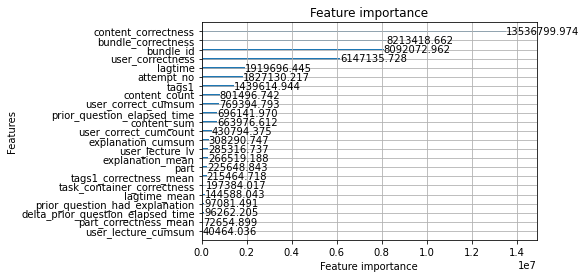

In [59]:

for i in range(0,num):

#     
    tr_data = lgb.Dataset(trains[i][features], label=trains[i][target])
    va_data = lgb.Dataset(valids[i][features], label=valids[i][target])
    
#     del train_df_clf
#     del valid_df
#     gc.collect()
    del trains
    del valids
    gc.collect()

    model = lgb.train(
        params, 
        tr_data,
#         train_df[features],
#         train_df[target],
        num_boost_round=5000,
        #valid_sets=[(train_df[features],train_df[target]), (valid_df[features],valid_df[target])], 
        valid_sets=[tr_data, va_data],
        early_stopping_rounds=50,
        feature_name=features,
        categorical_feature=categorical_columns,
        verbose_eval=50
    )
    clfs.append(model)
    #print('auc:', roc_auc_score(valid_df[target], model.predict(valid_df[features])))
    #model.save_model(f'model.txt')
    lgb.plot_importance(model, importance_type='gain')
    plt.show()

    del tr_data
    del va_data
    gc.collect()
#    
# del trains
# del valids
# gc.collect()

# Inference

In [60]:
user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))

del user_agg
del content_agg
gc.collect()

task_container_sum_dict = task_container_agg['sum'].astype('int32').to_dict(defaultdict(int))
task_container_count_dict = task_container_agg['count'].astype('int32').to_dict(defaultdict(int))
task_container_std_dict = task_container_agg['var'].astype('float16').to_dict(defaultdict(int))

explanation_sum_dict = explanation_agg['sum'].astype('int16').to_dict(defaultdict(int))
explanation_count_dict = explanation_agg['count'].astype('int16').to_dict(defaultdict(int))
del task_container_agg
del explanation_agg
gc.collect()

0

In [61]:
user_lecture_sum_dict = user_lecture_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_lecture_count_dict = user_lecture_agg['count'].astype('int16').to_dict(defaultdict(int))

lagtime_mean_dict = lagtime_agg['mean'].astype('int32').to_dict(defaultdict(int))
#del prior_question_elapsed_time_agg
del user_lecture_agg
del lagtime_agg
gc.collect()

20

In [62]:
attempt_no_agg=attempt_no_agg[attempt_no_agg['sum'] >1]
attempt_no_sum_dict = attempt_no_agg['sum'].to_dict(defaultdict(int))

del attempt_no_agg
gc.collect()

0

In [63]:
max_timestamp_u_dict=max_timestamp_u.set_index('user_id').to_dict()
user_prior_question_elapsed_time_dict=user_prior_question_elapsed_time.set_index('user_id').to_dict()
#del question_elapsed_time_agg
del max_timestamp_u
del user_prior_question_elapsed_time
gc.collect()

20

In [64]:
len(max_timestamp_u_dict['max_time_stamp'])

393656

In [65]:
def get_max_attempt(user_id,content_id):
    k = (user_id,content_id)

    if k in attempt_no_sum_dict.keys():
        attempt_no_sum_dict[k]+=1
        return attempt_no_sum_dict[k]

    attempt_no_sum_dict[k] = 1
    return attempt_no_sum_dict[k]

In [66]:
print(psutil.virtual_memory().percent)

30.7


# SAKT Part II

In [67]:
#HDKIM SAKT
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class FFN(nn.Module):
    def __init__(self, state_size=200):
        super(FFN, self).__init__()
        self.state_size = state_size

        self.lr1 = nn.Linear(state_size, state_size)
        self.relu = nn.ReLU()
        self.lr2 = nn.Linear(state_size, state_size)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.lr1(x)
        x = self.relu(x)
        x = self.lr2(x)
        return self.dropout(x)

def future_mask(seq_length):
    future_mask = np.triu(np.ones((seq_length, seq_length)), k=1).astype('bool')
    return torch.from_numpy(future_mask)

class SAKTModel(nn.Module):
    def __init__(self, n_skill, max_seq=MAX_SEQ, embed_dim=128): #HDKIM 100
        super(SAKTModel, self).__init__()
        self.n_skill = n_skill
        self.embed_dim = embed_dim

        self.embedding = nn.Embedding(2*n_skill+1, embed_dim)
        self.pos_embedding = nn.Embedding(max_seq-1, embed_dim)
        self.e_embedding = nn.Embedding(n_skill+1, embed_dim)

        self.multi_att = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=8, dropout=0.2)

        self.dropout = nn.Dropout(0.2)
        self.layer_normal = nn.LayerNorm(embed_dim) 

        self.ffn = FFN(embed_dim)
        self.pred = nn.Linear(embed_dim, 1)
    
    def forward(self, x, question_ids):
        device = x.device        
        x = self.embedding(x)
        pos_id = torch.arange(x.size(1)).unsqueeze(0).to(device)

        pos_x = self.pos_embedding(pos_id)
        x = x + pos_x

        e = self.e_embedding(question_ids)

        x = x.permute(1, 0, 2) # x: [bs, s_len, embed] => [s_len, bs, embed]
        e = e.permute(1, 0, 2)
        att_mask = future_mask(x.size(0)).to(device)
        att_output, att_weight = self.multi_att(e, x, x, attn_mask=att_mask)
        att_output = self.layer_normal(att_output + e)
        att_output = att_output.permute(1, 0, 2) # att_output: [s_len, bs, embed] => [bs, s_len, embed]

        x = self.ffn(att_output)
        x = self.layer_normal(x + att_output)
        x = self.pred(x)

        return x.squeeze(-1), att_weight
    
class TestDataset(Dataset):
    def __init__(self, samples, test_df, skills, max_seq=MAX_SEQ): #HDKIM 100
        super(TestDataset, self).__init__()
        self.samples = samples
        self.user_ids = [x for x in test_df["user_id"].unique()]
        self.test_df = test_df
        self.skills = skills
        self.n_skill = len(skills)
        self.max_seq = max_seq

    def __len__(self):
        return self.test_df.shape[0]

    def __getitem__(self, index):
        test_info = self.test_df.iloc[index]

        user_id = test_info["user_id"]
        target_id = test_info["content_id"]

        q = np.zeros(self.max_seq, dtype=int)
        qa = np.zeros(self.max_seq, dtype=int)

        if user_id in self.samples.index:
            q_, qa_ = self.samples[user_id]
            
            seq_len = len(q_)

            if seq_len >= self.max_seq:
                q = q_[-self.max_seq:]
                qa = qa_[-self.max_seq:]
            else:
                q[-seq_len:] = q_
                qa[-seq_len:] = qa_          
        
        x = np.zeros(self.max_seq-1, dtype=int)
        x = q[1:].copy()
        x += (qa[1:] == 1) * self.n_skill
        
        questions = np.append(q[2:], [target_id])
        
        return x, questions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAKT_model = SAKTModel(n_skill, embed_dim=128)

try:
    SAKT_model.load_state_dict(torch.load("../input/sakt-with-randomization-state-updates/SAKT-HDKIM.pt"))
except:
    SAKT_model.load_state_dict(torch.load("../input/sakt-with-randomization-state-updates/SAKT-HDKIM.pt", map_location='cpu'))

SAKT_model.to(device)
SAKT_model.eval()

import pickle
group = pickle.load(open("group.pkl", "rb"))

print(psutil.virtual_memory().percent)

#HDKIMHDKIM

32.1


In [68]:
# model = lgb.Booster(model_file='../input/riiid-lgbm-starter/model.txt')
env = riiideducation.make_env()

In [69]:
iter_test = env.iter_test()
prior_test_df = None

In [70]:
%%time

for (test_df, sample_prediction_df) in iter_test:    
    if (prior_test_df is not None) & (psutil.virtual_memory().percent<90):
        print(psutil.virtual_memory().percent)
        prior_test_df[target] = eval(test_df['prior_group_answers_correct'].iloc[0])
        prior_test_df = prior_test_df[prior_test_df[target] != -1].reset_index(drop=True)       
        prior_test_df['prior_question_had_explanation'].fillna(False, inplace=True)       
        prior_test_df.prior_question_had_explanation=prior_test_df.prior_question_had_explanation.astype('int8')
        
        #HDKIM SAKT State Update
        prev_group = prior_test_df[['user_id', 'content_id', 'answered_correctly']].groupby('user_id').apply(lambda r: (
            r['content_id'].values,
            r['answered_correctly'].values))
        for prev_user_id in prev_group.index:
            prev_group_content = prev_group[prev_user_id][0]
            prev_group_ac = prev_group[prev_user_id][1]
            if prev_user_id in group.index:
                group[prev_user_id] = (np.append(group[prev_user_id][0],prev_group_content), 
                                       np.append(group[prev_user_id][1],prev_group_ac))
            else:
                group[prev_user_id] = (prev_group_content,prev_group_ac)
            if len(group[prev_user_id][0])>MAX_SEQ:
                new_group_content = group[prev_user_id][0][-MAX_SEQ:]
                new_group_ac = group[prev_user_id][1][-MAX_SEQ:]
                group[prev_user_id] = (new_group_content,new_group_ac)

        #HDKIMHDKIM
    
        user_ids = prior_test_df['user_id'].values
        content_ids = prior_test_df['content_id'].values
        task_container_ids = prior_test_df['task_container_id'].values
        prior_question_had_explanations = prior_test_df['prior_question_had_explanation'].values
        targets = prior_test_df[target].values
       
        for user_id, content_id,prior_question_had_explanation,task_container_id,answered_correctly in zip(user_ids, content_ids, prior_question_had_explanations,task_container_ids,targets):
            user_sum_dict[user_id] += answered_correctly
            user_count_dict[user_id] += 1         
            explanation_sum_dict[user_id] += prior_question_had_explanation
            explanation_count_dict[user_id] += 1
            

    prior_test_df = test_df.copy()
    lecture_test_df = test_df[test_df['content_type_id'] == 1].reset_index(drop=True)
    
    for i, (user_id,content_type_id, content_id) in enumerate(zip(lecture_test_df['user_id'].values,lecture_test_df['content_type_id'].values,lecture_test_df['content_id'].values)):
      
        user_lecture_sum_dict[user_id] += content_type_id
        user_lecture_count_dict[user_id] += 1
        #
        if(len(user_lecture_stats_part[user_lecture_stats_part.user_id==user_id])==0):
            user_lecture_stats_part = user_lecture_stats_part.append([{'user_id':user_id}], ignore_index=True)
            user_lecture_stats_part.fillna(0, inplace=True)
            user_lecture_stats_part.loc[user_lecture_stats_part.user_id==user_id,part_lectures_columns + types_of_lectures_columns]+=lectures_df[lectures_df.lecture_id==content_id][part_lectures_columns + types_of_lectures_columns].values
        else:
            user_lecture_stats_part.loc[user_lecture_stats_part.user_id==user_id,part_lectures_columns + types_of_lectures_columns]+=lectures_df[lectures_df.lecture_id==content_id][part_lectures_columns + types_of_lectures_columns].values
  
        
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
   
    #HDKIM SAKT
    test_dataset = TestDataset(group, test_df, skills)
    test_dataloader = DataLoader(test_dataset, batch_size=51200, shuffle=False)
    
    SAKT_outs = []

    for item in test_dataloader:
        x = item[0].to(device).long()
        target_id = item[1].to(device).long()

        with torch.no_grad():
            output, att_weight = SAKT_model(x, target_id)
 
        output = torch.sigmoid(output)
        output = output[:, -1]
        SAKT_outs.extend(output.view(-1).data.cpu().numpy())
    
    #HDKIMHDKIM

    test_df['prior_question_had_explanation'].fillna(False, inplace=True)
    test_df.prior_question_had_explanation=test_df.prior_question_had_explanation.astype('int8')
    test_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)
    

    user_lecture_sum = np.zeros(len(test_df), dtype=np.int16)
    user_lecture_count = np.zeros(len(test_df), dtype=np.int16) 
    
    user_sum = np.zeros(len(test_df), dtype=np.int16)
    user_count = np.zeros(len(test_df), dtype=np.int16)
    content_sum = np.zeros(len(test_df), dtype=np.int32)
    content_count = np.zeros(len(test_df), dtype=np.int32)
    task_container_sum = np.zeros(len(test_df), dtype=np.int32)
    task_container_count = np.zeros(len(test_df), dtype=np.int32)
    task_container_std = np.zeros(len(test_df), dtype=np.float16)
    content_task_mean = np.zeros(len(test_df), dtype=np.float16)
    explanation_sum = np.zeros(len(test_df), dtype=np.int32)
    explanation_count = np.zeros(len(test_df), dtype=np.int32)
    delta_prior_question_elapsed_time = np.zeros(len(test_df), dtype=np.int32)

    attempt_no_count = np.zeros(len(test_df), dtype=np.int16)
    lagtime = np.zeros(len(test_df), dtype=np.int32)
    lagtime_mean = np.zeros(len(test_df), dtype=np.int32)
   
    
    for i, (user_id,prior_question_had_explanation,content_type_id,prior_question_elapsed_time,timestamp, content_id,task_container_id) in enumerate(zip(test_df['user_id'].values,test_df['prior_question_had_explanation'].values,test_df['content_type_id'].values,test_df['prior_question_elapsed_time'].values,test_df['timestamp'].values, test_df['content_id'].values, test_df['task_container_id'].values)):
         
        user_lecture_sum_dict[user_id] += content_type_id
        user_lecture_count_dict[user_id] += 1
        
        user_lecture_sum[i] = user_lecture_sum_dict[user_id]
        user_lecture_count[i] = user_lecture_count_dict[user_id]
        
        user_sum[i] = user_sum_dict[user_id]
        user_count[i] = user_count_dict[user_id]
        content_sum[i] = content_sum_dict[content_id]
        content_count[i] = content_count_dict[content_id]
        task_container_sum[i] = task_container_sum_dict[task_container_id]
        task_container_count[i] = task_container_count_dict[task_container_id]
        task_container_std[i]=task_container_std_dict[task_container_id]
      
        explanation_sum[i] = explanation_sum_dict[user_id]
        explanation_count[i] = explanation_count_dict[user_id]
  
        if user_id in max_timestamp_u_dict['max_time_stamp'].keys():
            lagtime[i]=timestamp-max_timestamp_u_dict['max_time_stamp'][user_id]
            max_timestamp_u_dict['max_time_stamp'][user_id]=timestamp
            lagtime_mean[i]=(lagtime_mean_dict[user_id]+lagtime[i])/2           
        else:
            lagtime[i]=0
            max_timestamp_u_dict['max_time_stamp'].update({user_id:timestamp})
            lagtime_mean_dict.update({user_id:timestamp})
            lagtime_mean[i]=(lagtime_mean_dict[user_id]+lagtime[i])/2
            
        if user_id in user_prior_question_elapsed_time_dict['prior_question_elapsed_time'].keys():            
            delta_prior_question_elapsed_time[i]=prior_question_elapsed_time-user_prior_question_elapsed_time_dict['prior_question_elapsed_time'][user_id]
            user_prior_question_elapsed_time_dict['prior_question_elapsed_time'][user_id]=prior_question_elapsed_time
        else:           
            delta_prior_question_elapsed_time[i]=0    
            user_prior_question_elapsed_time_dict['prior_question_elapsed_time'].update({user_id:prior_question_elapsed_time})
           
        
        
    
    #
    #test_df = pd.merge(test_df, questions_df, on='content_id', how='left',right_index=True)    
    #test_df = pd.concat([test_df.reset_index(drop=True), questions_df.reindex(test_df['content_id'].values).reset_index(drop=True)], axis=1)
    test_df=test_df.merge(questions_df.loc[questions_df.index.isin(test_df['content_id'])],
                  how='left', on='content_id', right_index=True)
    
    #test_df = pd.merge(test_df, user_lecture_stats_part, on=['user_id'], how="left",right_index=True)
    #test_df = pd.concat([test_df.reset_index(drop=True), user_lecture_stats_part.reindex(test_df['user_id'].values).reset_index(drop=True)], axis=1)
#     test_df=test_df.merge(user_lecture_stats_part.loc[user_lecture_stats_part.index.isin(test_df['user_id'])],
#                   how='left', on='user_id', right_index=True)
 
    test_df['user_lecture_lv'] = user_lecture_sum / user_lecture_count
    test_df['user_lecture_cumsum'] = user_lecture_sum
    test_df['user_correctness'] = user_sum / user_count
    test_df['user_correct_cumcount'] =user_count
    test_df['user_correct_cumsum'] =user_sum
    #
    test_df['content_correctness'] = content_sum / content_count
    test_df['content_count'] = content_count
    test_df['content_sum'] = content_sum
    
    test_df['task_container_correctness'] = task_container_sum / task_container_count
    test_df['task_container_sum'] = task_container_sum 
    test_df['task_container_std'] = task_container_std 
    #test_df['content_task_mean'] = content_task_mean 
    
    test_df['explanation_mean'] = explanation_sum / explanation_count
    test_df['explanation_cumsum'] = explanation_sum 
    
    #
    test_df['delta_prior_question_elapsed_time'] = delta_prior_question_elapsed_time 
    
  
 
    test_df["attempt_no"] = test_df[["user_id", "content_id"]].apply(lambda row: get_max_attempt(row["user_id"], row["content_id"]), axis=1)
    test_df["lagtime"]=lagtime
    test_df["lagtime_mean"]=lagtime_mean

    test_df['user_correctness'].fillna( 1, inplace=True)
    test_df['attempt_no'].fillna(1, inplace=True)
    #
    test_df.fillna(0, inplace=True)
    

    test_df['timestamp']=test_df['timestamp']/(1000*3600)
    test_df.timestamp=test_df.timestamp.astype('int16')


    sub_preds = np.zeros(test_df.shape[0])
    for i, model in enumerate(clfs, 1):
        test_preds  = model.predict(test_df[features])
        sub_preds += test_preds
    #HDKIM
    #test_df[target] = sub_preds / len(clfs) #HDKIM
    
    lgbm_final = sub_preds / len(clfs)   
    test_df[target] = np.array(SAKT_outs) * 0.5 + lgbm_final * 0.5
    #HDKIMHDKIM

    env.predict(test_df[['row_id', target]])

32.1
32.1
32.1
CPU times: user 1.28 s, sys: 61.1 ms, total: 1.34 s
Wall time: 921 ms
